# REading Waves


From the NOA buoy


In [ ]:
clear all
data = readtable('Buoy_data_realtime.txt');

In [ ]:
data;

In [ ]:
buoy.DateTime = datetime(data.Var1, data.Var2, data.Var3, data.Var4, data.Var5, 0);
plot(buoy.DateTime)


In [ ]:
url = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/098p1_rt.nc?waveTime[0:1:53737],waveTimeBounds[0:1:53737][0:1:1],waveFlagPrimary[0:1:53737],waveHs[0:1:53737],waveTp[0:1:53737],waveTa[0:1:53737],waveDp[0:1:53737],wavePeakPSD[0:1:53737],waveTz[0:1:53737],waveFrequency[0:1:63],waveFrequencyBounds[0:1:63][0:1:1],waveFrequencyFlagPrimary[0:1:63],waveBandwidth[0:1:63],waveEnergyDensity[0:1:0][0:1:0],waveMeanDirection[0:1:0][0:1:0],waveA1Value[0:1:0][0:1:0],waveB2Value[0:1:0][0:1:0],waveSpread[0:1:0][0:1:0],waveM2Value[0:1:0][0:1:0],waveN2Value[0:1:0][0:1:0],sstTime[0:1:53737],sstSeaSurfaceTemperature[0:1:53737],gpsTime[0:1:53737],gpsLatitude[0:1:53737],gpsLongitude[0:1:53737],dwrTime[0:1:53737],dwrZAccelerometerOffset[0:1:53737],dwrXAccelerometerOffset[0:1:53737],dwrYAccelerometerOffset[0:1:53737],dwrOrientation[0:1:53737],dwrInclination[0:1:53737],metaStationName,metaDeployLatitude,metaDeployLongitude,metaWaterDepth,metaDeclination,metaGridMapping';

% ncdisp(url);

NOAA.wTime = datetime(ncread(url, 'waveTime'), 'ConvertFrom','posixtime');
NOAA.wTimeBounds = datetime((ncread(url, 'waveTimeBounds')), 'ConvertFrom', 'posixtime');
NOAA.wHs = ncread(url, 'waveHs');

NOAA.wTa = ncread(url, 'waveTa'); % average wave period
NOAA.wDp = ncread(url, 'waveDp'); 
NOAA.wP_PSD = ncread(url, 'wavePeakPSD'); %peak wave power spectral density 
NOAA.wTp = ncread(url, 'waveTp');

% Now this would be frequency
NOAA.wf = ncread(url, 'waveFrequency');
NOAA.wf_Band = ncread(url, 'waveBandwidth');
NOAA.wf_E = ncread(url, 'waveEnergyDensity');
NOAA.wf_MeanDir = ncread(url,'waveMeanDirection');

% Temperature sensor
NOAA.sstTime = datetime(ncread(url, 'sstTime'), "ConvertFrom","posixtime");
NOAA.sst = ncread(url,'sstSeaSurfaceTemperature');

% GPS sensor
NOAA.gpsTime = datetime(ncread(url, 'gpsTime'), "ConvertFrom","posixtime");
NOAA.gpsLat = ncread(url, 'gpsLatitude');
NOAA.gpsLon = ncread(url, 'gpsLongitude');

% dwr sensor
NOAA.dwrTime = datetime(ncread(url, 'dwrTime'), "ConvertFrom", "posixtime");
NOAA.dwrZA = ncread(url, 'dwrZAccelerometerOffset');
NOAA.dwrXA = ncread(url, 'dwrXAccelerometerOffset');
NOAA.dwrYA = ncread(url, 'dwrYAccelerometerOffset');
NOAA.dwrOr = ncread(url, 'dwrOrientation');
NOAA.dwrIn = ncread(url, 'dwrInclination');



In [ ]:
date1 = datetime(2025,02,13,0,0,0);
date2 = datetime(2025,02,14, 0 ,0 ,0);

In [ ]:
plot(NOAA.sstTime, NOAA.sst)

ab = NOAA.sstTime < date2 & NOAA.sstTime > date1;

hold on
plot(NOAA.sstTime(ab), NOAA.sst(ab), 'xr');
xlim([datetime(2025, 02,12), datetime(2025,02,15)])
title('temperature')

In [ ]:
plot(NOAA.wTime, NOAA.wHs* 3.28084)
ab = NOAA.wTime < date2 & NOAA.wTime > date1;
hold on
plot(NOAA.wTime(ab), NOAA.wHs(ab) * 3.28084, 'r')
xlim([datetime(2025, 02,22), datetime(2025,02,28)])

In [ ]:
plot(NOAA.wTime, NOAA.wTp)
hold on
plot(NOAA.wTime(ab), NOAA.wTa(ab), 'rx')
xlim([datetime(2025, 02,12), datetime(2025,02,15)])

In [ ]:
plot(NOAA.wTime, NOAA.wDp, '.')
hold on
plot(NOAA.wTime(ab), NOAA.wDp(ab), 'r.')
xlim([datetime(2025, 02,12), datetime(2025,02,28)])

In [ ]:
plot(NOAA.wTime, NOAA.wP_PSD); hold on
plot(NOAA.wTime(ab), NOAA.wP_PSD(ab), 'r.')
xlim([datetime(2025, 02,12), datetime(2025,02,15)])

In [ ]:
NOAA.wf_E  

In [ ]:
plot(NOAA.dwrTime, NOAA.dwrIn); hold on
ab = NOAA.dwrTime < date2 & NOAA.dwrTime > date1;
plot(NOAA.dwrTime(ab), NOAA.dwrIn(ab), '.');
xlim([datetime(2025, 02,12), datetime(2025,02,15)]);



In [ ]:
ab = NOAA.wTime < date2 & NOAA.wTime > date1;

theta = deg2rad(NOAA.wDp(ab)); % Convert degrees to radians
r = NOAA.wTp(ab); % Length of the vector
c = NOAA.wP_PSD(ab); % Color by spectral density

% Create a polar plot
figure;
polarplot(theta, r, 'o');

% Create a colormap based on spectral density
colormap(jet);
caxis([min(c) max(c)]);
colorbar;

% Add color to the plot
hold on;
for i = 1:length(theta)
    polarplot([0 theta(i)], [0 r(i)], 'Color', [c(i)/max(c) 0 1-c(i)/max(c)]);
end

title('Wind Rose Contour');

# Glider data try out


In [1]:
glider_data = readtable('glider_data.txt');

Set 'VariableNamingRule' to 'preserve' to use the original column headers as table variable names.


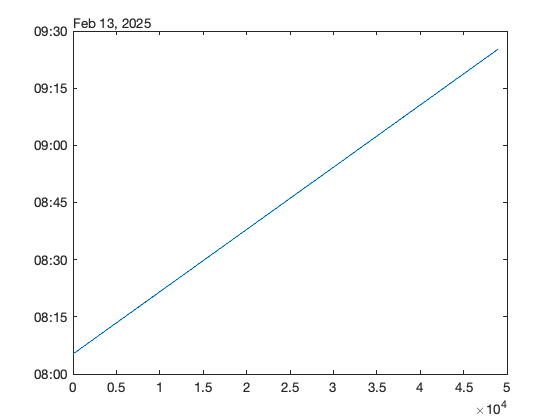

In [2]:
plot(glider_data.Timestamp)

In [3]:
glider_data(1:5, :)




ans =

  5x11 table

         Timestamp         Quad_0_    Quad_1_    Quad_2_     Quad_3_     PQR_0_      PQR_1_     PQR_2_     ACC_0_     ACC_1_     ACC_2_ 
    ___________________    _______    _______    ________    _______    ________    ________    _______    _______    ______    ________

    2025-02-13 08:05:15    0.42353    0.17676    -0.06036    0.88642    -0.08178    -0.04085    0.04337    -3.1158    8.9454     -0.2185
    2025-02-13 08:05:15    0.42275    0.17345    -0.06288    0.88727    -0.07495    -0.04282    0.03635    -3.1595    8.9004    -0.23389
    2025-02-13 08:05:15    0.42217    0.17087    -0.06451    0.88793     -0.0563    -0.03247    0.03191    -3.1804    8.9089    -0.27861
    2025-02-13 08:05:15    0.42192    0.16879    -0.06493    0.88841    -0.02906    -0.01808    0.03823    -3.1738    8.9686    -0.21949
    2025-02-13 08:05:15    0.42217    0.16753    -0.06364    0.88863    -0.00342    -0.00301     0.0421    -3.2624    9.0228    -0.21199



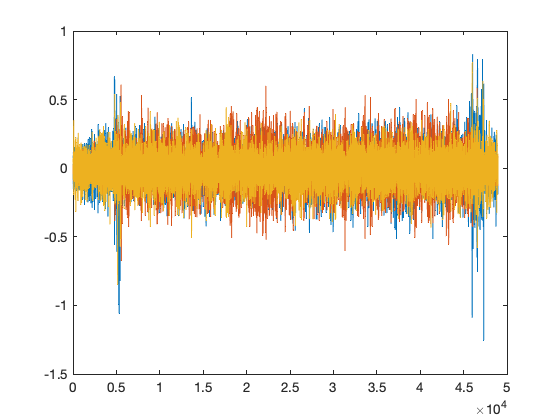

In [4]:
plot(glider_data.PQR_0_); hold on
plot(glider_data.PQR_1_);
plot(glider_data.PQR_2_);

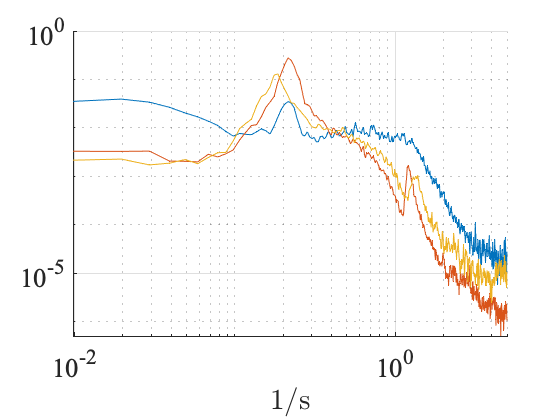

In [5]:

figure('position', [10 10 700 300])
[P,k]=fast_psd(glider_data.PQR_0_,2^10,10);
[P2,k]=fast_psd(glider_data.PQR_1_,2^10,10);
[P3,k]=fast_psd(glider_data.PQR_2_,2^10,10);

loglog(k,P); hold on
loglog(k,P2);
loglog(k,P3)

grid on
% ginput(3)

xlabel('1/s')
pretty_font

% export_fig first_test.pdf


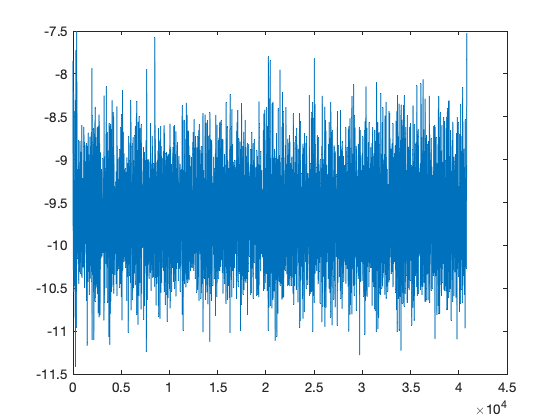

In [6]:
ac = glider_data.ACC_0_ < -7.5;
data = glider_data.ACC_0_(ac);

plot(data); hold on

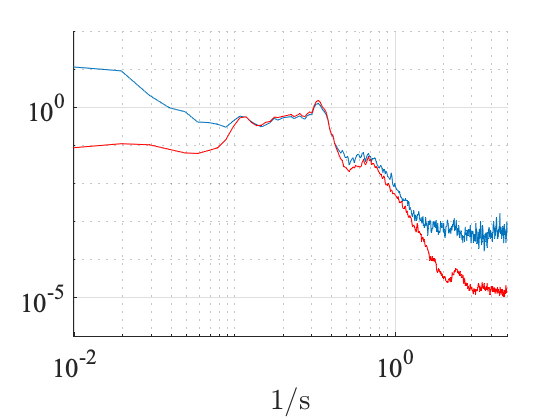

In [8]:

figure('position', [10 10 700 300])
[P,k]=fast_psd(glider_data.ACC_0_,2^10,10);
[Pi,k]=fast_psd(data,2^10,10);
% [P2,k]=fast_psd(glider_data.Var10,2^10,10);
% [P3,k]=fast_psd(glider_data.Var11,2^10,10);

loglog(k,P); hold on
loglog(k,Pi, 'r');
% loglog(k,P2);
% loglog(k,P3)

grid on
% ginput(3)

xlabel('1/s')
pretty_font

% export_fig first_test.pdf


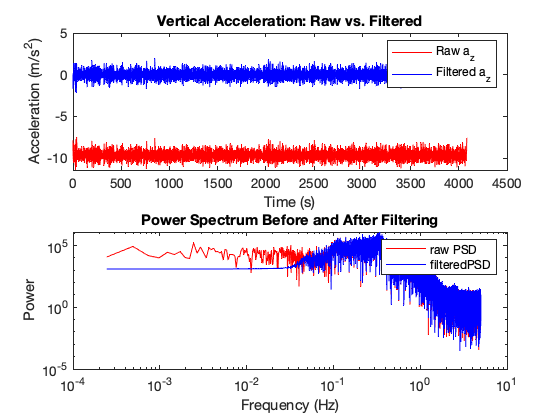

In [9]:
% Load or define your vertical acceleration data (a_z)
fs = 10; % Sampling frequency in Hz (adjust if needed)
fc = 0.05; % Cutoff frequency in Hz (remove drift below this)

% Design a 4th-order Butterworth high-pass filter
order = 4;  
Wn = fc / (fs/2); % Normalize frequency
[b, a] = butter(order, Wn, 'high');

% Apply the filter to the vertical acceleration data
a_z_filtered = filtfilt(b, a, data); % Assuming glider_data.Var9 is your vertical acceleration data
a_z = data; % Original vertical acceleration data
% Plot the original and filtered data
% Plot before and after filtering
t = (0:length(a_z)-1) / fs; % Time vector

figure;
subplot(2,1,1)
plot(t, a_z, 'r'); hold on;
plot(t, a_z_filtered, 'b');
legend('Raw a_z', 'Filtered a_z');
xlabel('Time (s)');
ylabel('Acceleration (m/s^2)');
title('Vertical Acceleration: Raw vs. Filtered');

subplot(2,1,2)
psd_raw = abs(fft(a_z)).^2; 
psd_filtered = abs(fft(a_z_filtered)).^2; 
f = linspace(0, fs/2, length(psd_raw)/2);

loglog(f, psd_raw(1:end/2), 'r'); hold on;
loglog(f, psd_filtered(1:end/2), 'b'); hold on


legend( 'raw PSD', 'filteredPSD');
xlabel('Frequency (Hz)');
ylabel('Power');
title('Power Spectrum Before and After Filtering');



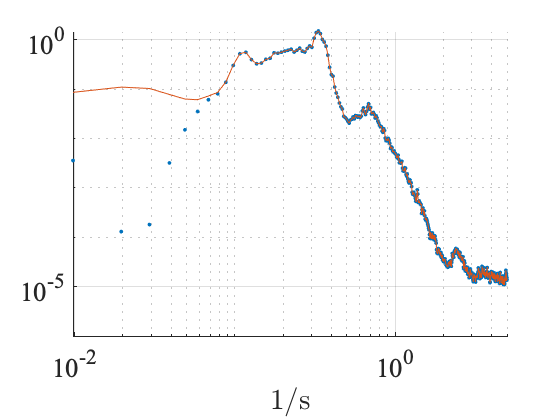

In [28]:

figure('position', [10 10 700 300])
[P,k]=fast_psd(a_z_filtered,2^10,10);
[P2,k]=fast_psd(data,2^10,10);
% [P2,k]=fast_psd(glider_data.Var10,2^10,10);
% [P3,k]=fast_psd(glider_data.Var11,2^10,10);

loglog(k,P, '.'); hold on
 loglog(k,P2);
% loglog(k,P3)


grid on
% ginput(3)

xlabel('1/s')
pretty_font


In [ ]:
% edit fast_psd.m

In [ ]:
whos  S_eta P_eta P S_a_z k f 

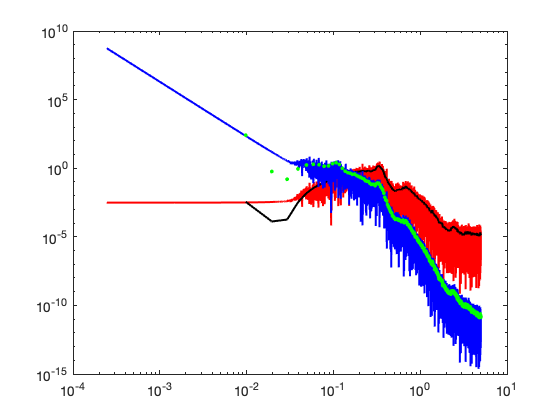

In [24]:
% Given parameters
fs = 10; % Sampling frequency in Hz (adjust as needed)
N = length(a_z_filtered); % Number of data points
dt = 1/fs; % Time step
f = (0:N/2-1) * (fs/N); % Frequency vector (one-sided)

% % Compute acceleration power spectral density (PSD)
A_z = fft(a_z_filtered); % Compute FFT
S_a_z = (abs(A_z).^2) / (N * fs); % Compute PSD (single-sided)
S_a_z = S_a_z(1:N/2); % Keep only positive frequencies


[P,k]=fast_psd(a_z_filtered,2^10,10);

% % Convert acceleration PSD to displacement PSD
S_eta = S_a_z ./ ( (2 * pi * f').^4 ); 
P_eta = P ./ ( (2 * pi * k).^4 ); 

% % Handle f = 0 case to avoid division by zero
P_eta(k == 0) = 0; 

% % Plot results
% figure;

loglog(f, S_a_z, 'r', 'LineWidth', 1.5); hold on;
loglog(k, P, 'k', 'LineWidth', 1.5); hold on;

loglog(f, S_eta, 'b', 'LineWidth', 1.5);
loglog(k, P_eta, 'g.', 'LineWidth', 1.5);
% legend('Acceleration PSD', 'Displacement PSD');
% xlabel('Frequency (Hz)');
% ylabel('Power Spectral Density');
% title('Conversion from Acceleration to Displacement Spectrum');
% grid on;


In [41]:
5*10^-2


ans =

    0.0500



In [12]:
% Step 1: Calculate m0 (zero-th moment of the displacement spectrum)
% m0 = trapz(f, S_eta);  % Numerical integration of S_eta over frequency
m0_p = trapz(k, P_eta);  % Numerical integration of S_eta over frequency

% Step 2: Calculate Significant Wave Height (H_s)
% H_s = 4 * sqrt(m0);
H_sp = 4 * sqrt(m0_p);

% Display result

disp(['Significant Wave Height Hs: ', num2str(H_sp), ' meters']);

Significant Wave Height Hs: 1.8514 meters


In [ ]:
% Step 1: Find the dominant frequency (frequency with maximum displacement spectrum)
[~, idx_peak] = max(P_eta)  % Find index of maximum displacement spectrum

if idx
f_peak = k(idx_peak);  % Dominant frequency

% Step 2: Calculate the peak period (T_peak) from the dominant frequency
T_peak = 1 / f_peak;

% Display results
disp(['Dominant Frequency: ', num2str(f_peak), ' Hz']);
disp(['Peak Period: ', num2str(T_peak), ' seconds']);


idx_peak =

     1



Dominant Frequency: 0.0097656 Hz
Peak Period: 102.4 seconds


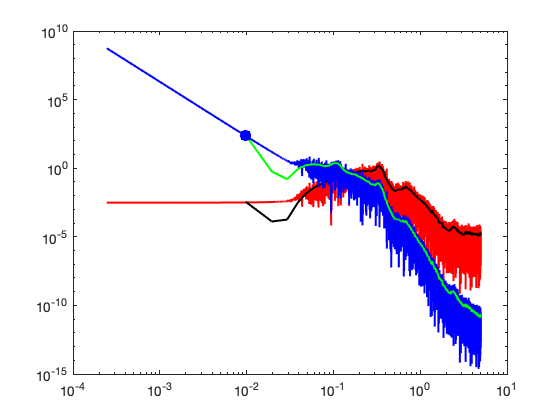

In [43]:
% % Plot results
% figure;

loglog(f, S_a_z, 'r', 'LineWidth', 1.5); hold on;
loglog(k, P, 'k', 'LineWidth', 1.5); hold on;

loglog(f, S_eta, 'b', 'LineWidth', 1.5);
loglog(k, P_eta, 'g', 'LineWidth', 1.5);

line(f_peak, P_eta(idx_peak), 'Marker', 'o', 'Color', 'b', 'MarkerSize', 8, 'MarkerFaceColor', 'b');

In [15]:
% Step 1: Find the dominant frequency (peak frequency)
[~, idx_peak] = max(P_eta);  % Find index of maximum displacement spectrum
f_peak = k(idx_peak);  % Dominant frequency

% Step 2: Define a frequency range around the peak (e.g., ±20% of the peak frequency)
freq_range = [f_peak * 0.8, f_peak * 1.2]  % Range around the peak frequency

% Step 3: Find indices for the frequency range
freq_indices = find(k >= freq_range(1) & k <= freq_range(2));

% Step 4: Integrate over the selected frequency range (S_eta over the range)
m0 = trapz(k(freq_indices), P_eta(freq_indices));  % Numerical integration over the selected range

% Step 5: Calculate Significant Wave Height (H_s)
H_s = 4 * sqrt(m0);

% Display result
disp(['Significant Wave Height Hs: ', num2str(H_s), ' meters']);



freq_range =

    0.0859    0.1289

Significant Wave Height Hs: 1.1046 meters


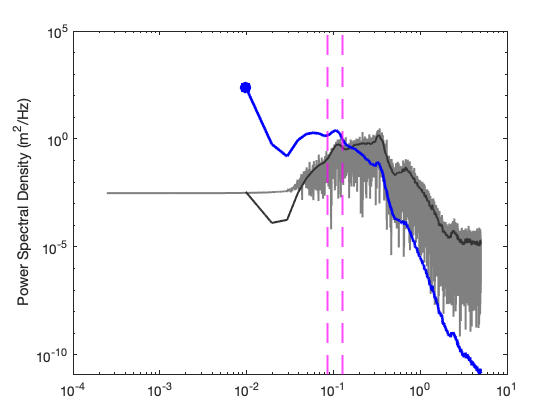

In [44]:
% % Plot results
% figure;

loglog(f, S_a_z, 'color', [.5 .5 .5],'LineWidth', 1.5); hold on;
loglog(k, P, 'k', 'color', [.2 .2 .2] ,'LineWidth', 1.5); hold on;

% loglog(f, S_eta, 'color', 'LineWidth', 1.5);
loglog(k, P_eta, 'b', 'LineWidth', 2);

line(f_peak, P_eta(idx_peak), 'Marker', 'o', 'Color', 'b', 'MarkerSize', 8, 'MarkerFaceColor', 'b');
xline(freq_range(1), 'm--', 'LineWidth', 1.5);
xline(freq_range(2), 'm--', 'LineWidth', 1.5);

ylabel('Power Spectral Density (m^2/Hz)');


In [ ]:
fs = 100; % Sampling frequency (Hz)
t = 0:1/fs:10-1/fs; % Time vector (10 seconds)
y = 3*sin(2*pi*2*t) + 2*cos(2*pi*5*t) + 0.5*randn(size(t)); % Signal with noise

frequencies = [2]; % Known frequencies (Hz)

X = []; % Design matrix
for f = frequencies
    X = [X, cos(2*pi*f*t)', sin(2*pi*f*t)'];
end

coeffs = X \ y'; % Solve using least squares
amplitudes = sqrt(coeffs(1:2:end).^2 + coeffs(2:2:end).^2);
phases = atan2(-coeffs(2:2:end), coeffs(1:2:end));

y_reconstructed = X * coeffs;

figure;
plot(t, y, 'k', 'DisplayName', 'Original Signal'); hold on;
plot(t, y_reconstructed, 'r--', 'DisplayName', 'Reconstructed Signal');
xlabel('Time (s)');
ylabel('Amplitude');
legend;
title('Time Series Decomposition into Known Frequencies');
grid on;

In [ ]:
whos data

# Testing the code

Significant Wave Height Hs: 1.1202 meters
Dominant Frequency: 0.10742 Hz
Peak Period: 9.3091 seconds

P_eta =

   1.0e+03 *

    2.6420
    0.0051
    0.0001
    0.0000
    0.0000
    0.0000
    0.0001
    0.0004
    0.0008
    0.0015
    0.0018
    0.0015
    0.0019
    0.0019
    0.0014
    0.0013
    0.0011
    0.0013
    0.0014
    0.0023
    0.0025
    0.0026
    0.0026
    0.0022
    0.0015
    0.0008
    0.0006
    0.0006
    0.0005
    0.0004
    0.0004
    0.0004
    0.0004
    0.0004
    0.0003
    0.0004
    0.0003
    0.0003
    0.0003
    0.0003
    0.0002
    0.0002
    0.0002
    0.0002
    0.0002
    0.0002
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0001
    0.0000
    0.0000
    0.0000
    0.0000
    0.0000
    0.0000
    0.0000
    0.0000
    0.0000
    0.

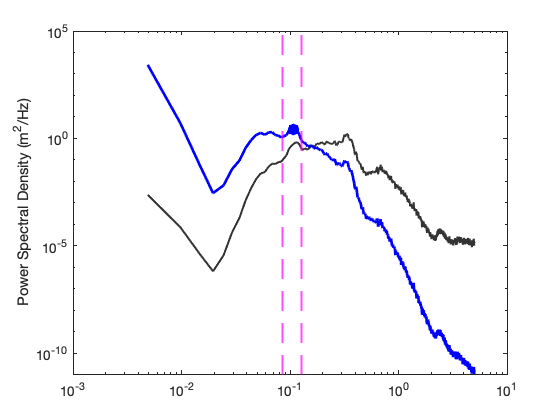

In [54]:
ac = glider_data.ACC_0_ < -7.5;
data = glider_data.ACC_0_(ac);

[P_eta, k,a_z_filtered, H_s, f_peak, T_peak, t] = stat_wave_1D(data, 10, 0.05)

# Now buoy


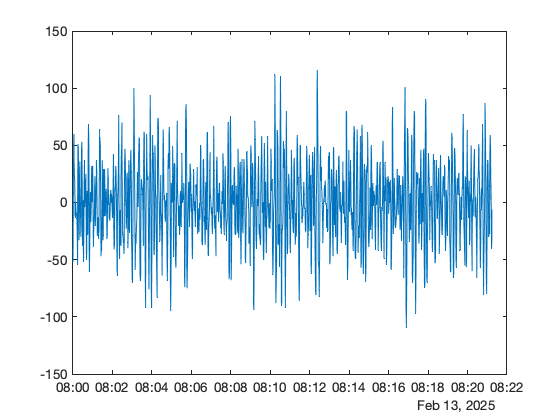

In [72]:
buoy = readtable('buoy_data.txt');
time  = datetime(num2str(buoy.time), 'InputFormat', 'yyyyMMddHHmmss');
plot(time, buoy.V)

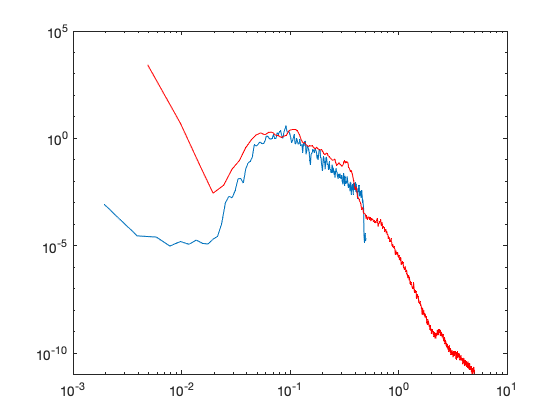

In [79]:
[B,kb]=fast_psd(buoy.V./100,2^9,1);
loglog(kb,B); hold on
loglog(k, P_eta, 'r'); hold on


In [80]:
% Step 1: Find the dominant frequency (peak frequency)
[~, idx_peak] = max(B);  % Find index of maximum displacement spectrum
f_peak_b = kb(idx_peak);  % Dominant frequency

% Step 2: Define a frequency range around the peak (e.g., ±20% of the peak frequency)
freq_range_b = [f_peak_b * 0.8, f_peak_b * 1.2]  % Range around the peak frequency

% Step 3: Find indices for the frequency range
freq_indices_b = find(kb >= freq_range_b(1) & kb <= freq_range_b(2));

% Step 4: Integrate over the selected frequency range (S_eta over the range)
m0b = trapz(kb(freq_indices_b), B(freq_indices_b));  % Numerical integration over the selected range

% Step 5: Calculate Significant Wave Height (H_s)
H_s_b = 4 * sqrt(m0b);

% Display result
disp(['Significant Wave Height Hs: ', num2str(H_s_b), ' meters']);
T_peak_b = 1 / f_peak_b;

% Display results
disp(['Dominant Frequency: ', num2str(f_peak_b), ' Hz']);
disp(['Peak Period: ', num2str(T_peak_b), ' seconds']);


freq_range_b =

    0.0734    0.1102

Significant Wave Height Hs: 0.98509 meters
Dominant Frequency: 0.091797 Hz
Peak Period: 10.8936 seconds


In [62]:
buoy


buoy =

  0x0 empty table



# Trying out directional